# ShellJob

## Introduction
`ShellJob` is a built-in task, which uses the [aiida-shell](https://aiida-shell.readthedocs.io/en/latest/) package to run shell commands easy. Run any shell executable without writing a dedicated plugin or parser.

This tutorial is based on the [docs](https://aiida-shell.readthedocs.io/en/latest/howto.html#) of the `aiida-shell`

Load the AiiDA profile.

In [1]:
%load_ext aiida
from aiida import load_profile
load_profile()

Profile<uuid='bcf9e395e4bf4b64a0a705d8659c0a9c' name='default'>

## Running a shell command
Run a shell command without any arguments. Here we run the `date` command to show the date.

In [2]:
from aiida_workgraph import WorkGraph

wg = WorkGraph(name="test_shell_date")
date_task = wg.add_task("ShellJob", command="date")
wg.submit(wait=True)

# Print out the result:
print("\nResult: ", date_task.outputs['stdout'].value.get_content())

WorkGraph process created, PK: 29659

Result:  Fr 12 Jul 2024 12:32:18 CEST



## Running a shell command with arguments
To pass arguments to the shell command, pass them as a list of strings to the arguments keyword:

In [3]:
# Create a workgraph
wg = WorkGraph(name="test_shell_date_with_arguments")
date_task = wg.add_task("ShellJob", command="date", arguments=['--iso-8601'])
wg.submit(wait=True)

# Print out the result:
print("\nResult: ", date_task.outputs['stdout'].value.get_content())

WorkGraph process created, PK: 29669

Result:  2024-07-12



## Running a shell command with files as arguments
For commands that take arguments that refer to files, pass those files using the nodes keyword. The keyword takes a dictionary of SinglefileData nodes. To specify where on the command line the files should be passed, use placeholder strings in the arguments keyword.

In [4]:
from aiida.orm import SinglefileData

wg = WorkGraph(name="test_shell_cat_with_file_arguments")
cat_task = wg.add_task("ShellJob", command="cat",
                    arguments=["{file_a}", "{file_b}"],
                    nodes={
                        'file_a': SinglefileData.from_string('string a'),
                        'file_b': SinglefileData.from_string('string b'),
                    },
                    )
wg.submit(wait=True)

# Print out the result:
print("\nResult: ", cat_task.outputs['stdout'].value.get_content())

WorkGraph process created, PK: 29681

Result:  string astring b


## Create a workflow
We want to calculate `(x+y)*z` in two steps using `echo` and `bc` commands.

Step 1: Calculate (x+y) and store it as result
```
result=$(echo "$x + $y" | bc)
```

Step 2: Multiply result by z and store the final result
```
result=$(echo "$result * $z" | bc)
```
Each step will invole two `ShellJob` (`echo` and `bc`).

If one wanted to run this workflow in AiiDA, one would have to write plugins for `echo` and `bc` commands, and a WorkChain to handle the workflow. With aiida-workgraph, this can be run with the following workgraph:

In [5]:
from aiida_workgraph import WorkGraph
from aiida.orm import Int
from aiida_shell.data import PickledData
from aiida import load_profile

load_profile()


def parser(self, dirpath):
    from aiida.orm import Int
    return {'result': Int((dirpath / 'stdout').read_text().strip())}

# Create a workgraph
wg = WorkGraph(name="shell_add_mutiply_workflow")
# echo x + y expression
echo_task_1 = wg.add_task("ShellJob", name="echo_task_1", command="echo", arguments=["{x}", "+", "{y}"],
                    nodes={'x': Int(2),
                        'y': Int(3)},
                )
# bc command to calculate the expression
bc_task_1 = wg.add_task("ShellJob", name="bc_task_1", command="bc", arguments=["{expression}"],
                    parser=PickledData(parser),
                    nodes={'expression': echo_task_1.outputs["stdout"]},
                    parser_outputs=[{"name": "result"}],
                )
# echo result + z expression
echo_task_2 = wg.add_task("ShellJob", name="echo_task_2", command="echo",
                    arguments=["{result}", "*", "{z}"],
                    nodes={'z': Int(4),
                           "result": bc_task_1.outputs["result"]},
                    )
# bc command to calculate the expression
bc_task_2 = wg.add_task("ShellJob", name="bc_task_2", command="bc", arguments=["{expression}"],
                    parser=PickledData(parser),
                    nodes={'expression': echo_task_2.outputs["stdout"]},
                    parser_outputs=[{"name": "result"}],
                )
display(wg.to_html())
wg.submit(wait=True, timeout=100)

WorkGraph process created, PK: 29696


<WorkChainNode: uuid: 00a1bb87-73f4-4427-811f-c838833e6490 (pk: 29696) (aiida_workgraph.engine.workgraph.WorkGraphEngine)>

In [6]:
print("State of WorkGraph    : {}".format(wg.state))
print('Result               : {}'.format(bc_task_2.node.outputs.result.value))

State of WorkGraph    : FINISHED
Result               : 20


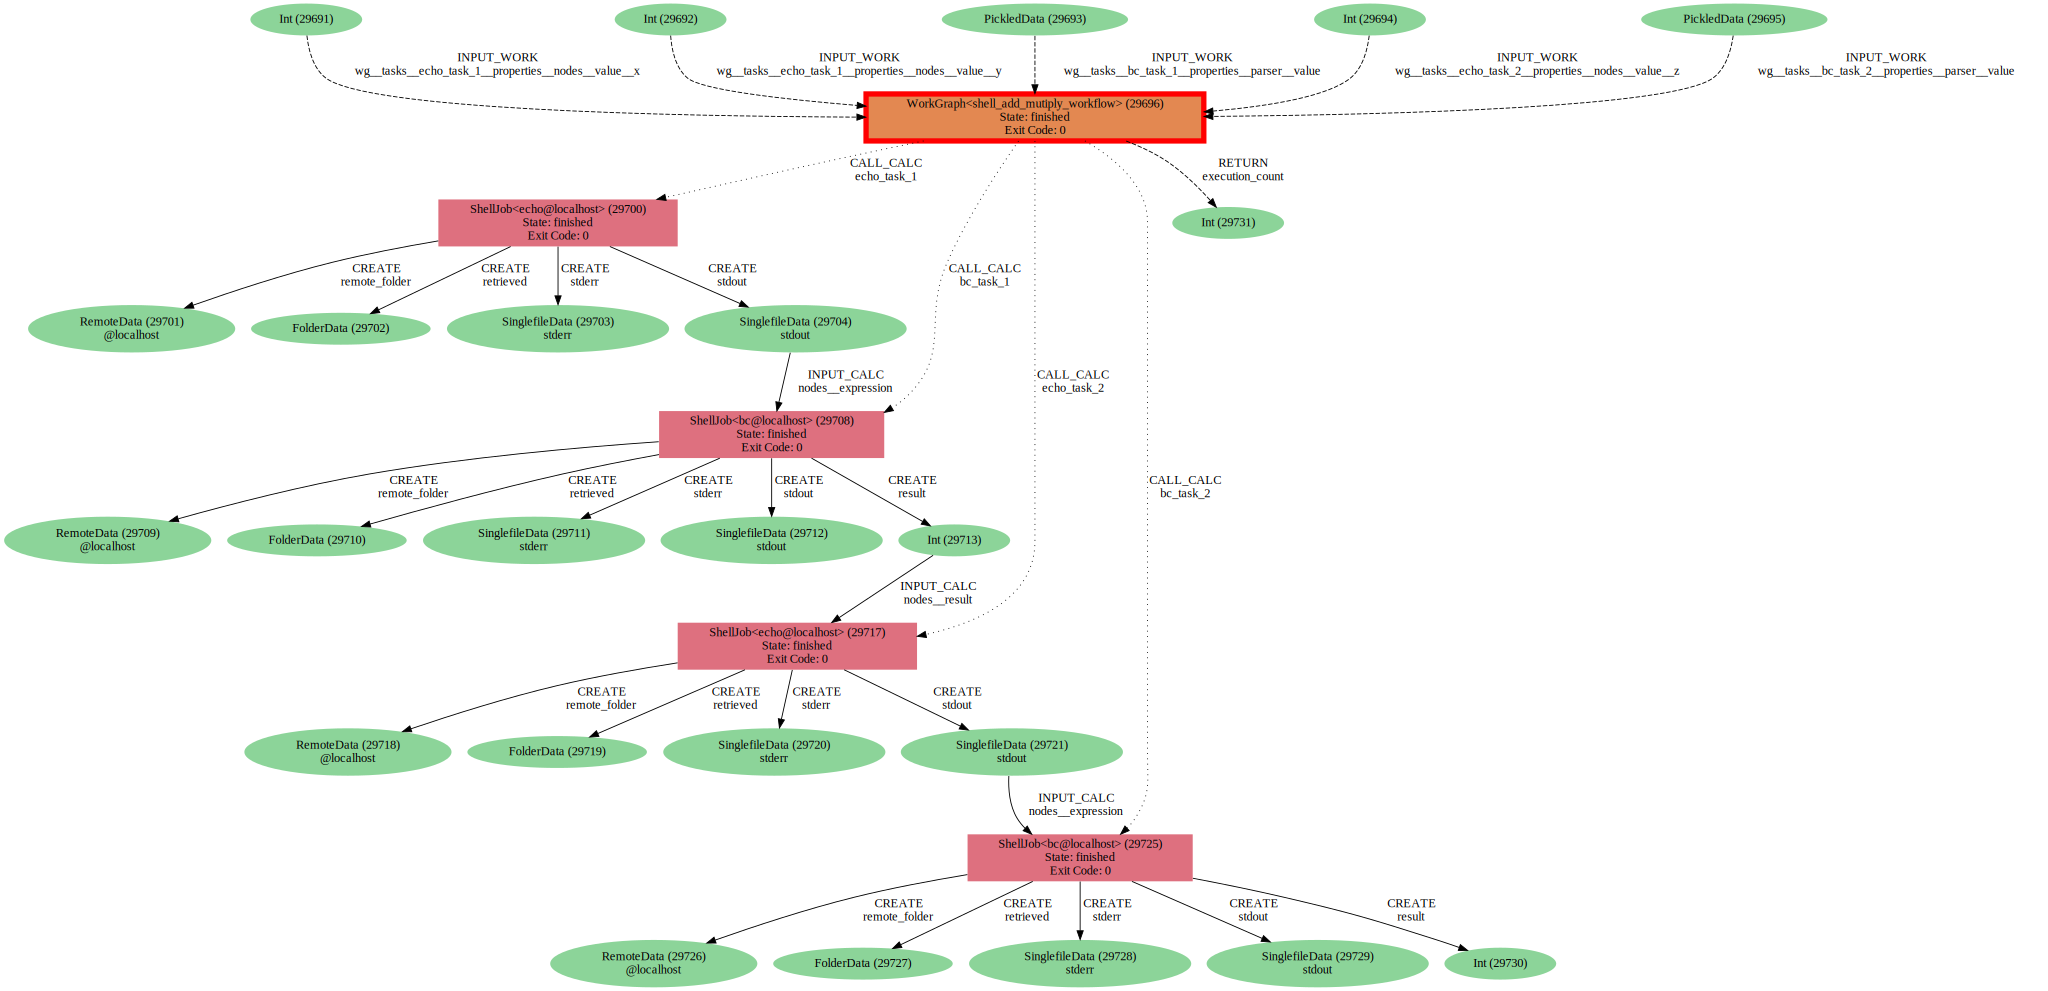

In [7]:
from aiida_workgraph.utils import generate_node_graph
generate_node_graph(wg.pk)

## What's Next
For more examples of `aiida-shell`, please refer to its [docs](https://aiida-shell.readthedocs.io/en/latest/howto.html#)